# Method 6 - Best Ideas High Minus Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
low_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

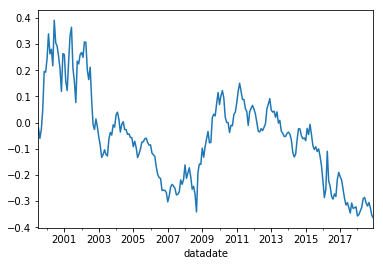

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.192302
2000-12-31    0.059520
2001-12-31   -0.002985
2002-12-31   -0.219086
2003-12-31   -0.001100
2004-12-31   -0.040935
2005-12-31   -0.030565
2006-12-31   -0.197960
2007-12-31    0.068042
2008-12-31    0.073299
2009-12-31    0.327186
2010-12-31   -0.067049
2011-12-31    0.024659
2012-12-31    0.024222
2013-12-31   -0.121552
2014-12-31   -0.018159
2015-12-31   -0.114378
2016-12-31   -0.028786
2017-12-31   -0.162882
2018-12-31   -0.062496
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     8.906
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-06
Time:                        14:45:59   Log-Likelihood:                 401.20
No. Observations:                 234   AIC:                            -792.4
Df Residuals:                     229   BIC:                            -775.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.003     -0.252      0.801      -0.007       0.005
mktrf          0.0564      0.082      0.687      0.493      -0.105       0.218
me             0.2322      0.096      2.430      0.016       0.044       0.420
ia             0.0701      0.145      0.483      0.630      -0.216       0.356
roe           -0.3820      0.124     -3.073      0.002      -0.627      -0.137
==============================================================================
Omnibus:                      106.982   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              682.589
Skew:                           1.679   Prob(JB):                    5.99e-149
Kurtosis:                      10.664   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     6.009
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000129
Time:                        14:45:59   Log-Likelihood:                 401.20
No. Observations:                 234   AIC:                            -792.4
Df Residuals:                     229   BIC:                            -775.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.003     -0.244      0.807      -0.007       0.005
mktrf          0.0564      0.156      0.363      0.717      -0.248       0.361
me             0.2322      0.105      2.206      0.027       0.026       0.438
ia             0.0701      0.173      0.405      0.686      -0.269       0.409
roe           -0.3820      0.151     -2.524      0.012      -0.679      -0.085
==============================================================================
Omnibus:                      106.982   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              682.589
Skew:                           1.679   Prob(JB):                    5.99e-149
Kurtosis:                      10.664   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     7.407
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.26e-05
Time:                        14:45:59   Log-Likelihood:                 401.20
No. Observations:                 234   AIC:                            -792.4
Df Residuals:                     229   BIC:                            -775.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.003     -0.242      0.809      -0.007       0.005
mktrf          0.0564      0.153      0.368      0.713      -0.244       0.357
me             0.2322      0.118      1.970      0.049       0.001       0.463
ia             0.0701      0.190      0.369      0.712      -0.303       0.443
roe           -0.3820      0.159     -2.395      0.017      -0.695      -0.069
==============================================================================
Omnibus:                      106.982   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              682.589
Skew:                           1.679   Prob(JB):                    5.99e-149
Kurtosis:                      10.664   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     10.15
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.66e-09
Time:                        14:45:59   Log-Likelihood:                 407.79
No. Observations:                 234   AIC:                            -803.6
Df Residuals:                     228   BIC:                            -782.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.136      0.892      -0.006       0.005
mktrf          0.0798      0.080      0.995      0.321      -0.078       0.238
smb            0.1645      0.106      1.554      0.121      -0.044       0.373
hml           -0.1436      0.125     -1.151      0.251      -0.389       0.102
rmw           -0.4937      0.141     -3.500      0.001      -0.772      -0.216
cma            0.3248      0.179      1.812      0.071      -0.028       0.678
==============================================================================
Omnibus:                       98.247   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              549.567
Skew:                           1.562   Prob(JB):                    4.60e-120
Kurtosis:                       9.827   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     14.07
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.34e-12
Time:                        14:45:59   Log-Likelihood:                 407.79
No. Observations:                 234   AIC:                            -803.6
Df Residuals:                     228   BIC:                            -782.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.132      0.895      -0.006       0.006
mktrf          0.0798      0.107      0.744      0.457      -0.131       0.290
smb            0.1645      0.118      1.389      0.165      -0.068       0.397
hml           -0.1436      0.185     -0.776      0.438      -0.506       0.219
rmw           -0.4937      0.135     -3.669      0.000      -0.757      -0.230
cma            0.3248      0.172      1.885      0.059      -0.013       0.663
==============================================================================
Omnibus:                       98.247   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              549.567
Skew:                           1.562   Prob(JB):                    4.60e-120
Kurtosis:                       9.827   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     17.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-14
Time:                        14:45:59   Log-Likelihood:                 407.79
No. Observations:                 234   AIC:                            -803.6
Df Residuals:                     228   BIC:                            -782.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.128      0.899      -0.007       0.006
mktrf          0.0798      0.109      0.735      0.462      -0.133       0.293
smb            0.1645      0.132      1.250      0.211      -0.093       0.422
hml           -0.1436      0.178     -0.805      0.421      -0.493       0.206
rmw           -0.4937      0.144     -3.426      0.001      -0.776      -0.211
cma            0.3248      0.149      2.179      0.029       0.033       0.617
==============================================================================
Omnibus:                       98.247   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              549.567
Skew:                           1.562   Prob(JB):                    4.60e-120
Kurtosis:                       9.827   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     9.869
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.20e-07
Time:                        14:45:59   Log-Likelihood:                 402.90
No. Observations:                 234   AIC:                            -795.8
Df Residuals:                     229   BIC:                            -778.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.601      0.549      -0.007       0.004
mktrf          0.1135      0.075      1.512      0.132      -0.034       0.261
smb            0.4144      0.094      4.422      0.000       0.230       0.599
hml           -0.1259      0.093     -1.352      0.178      -0.309       0.058
umd           -0.1045      0.061     -1.712      0.088      -0.225       0.016
==============================================================================
Omnibus:                      105.708   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              672.717
Skew:                           1.655   Prob(JB):                    8.34e-147
Kurtosis:                      10.619   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     8.027
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.51e-06
Time:                        14:45:59   Log-Likelihood:                 402.90
No. Observations:                 234   AIC:                            -795.8
Df Residuals:                     229   BIC:                            -778.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.597      0.550      -0.007       0.004
mktrf          0.1135      0.129      0.881      0.378      -0.139       0.366
smb            0.4144      0.094      4.395      0.000       0.230       0.599
hml           -0.1259      0.155     -0.811      0.417      -0.430       0.178
umd           -0.1045      0.072     -1.457      0.145      -0.245       0.036
==============================================================================
Omnibus:                      105.708   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              672.717
Skew:                           1.655   Prob(JB):                    8.34e-147
Kurtosis:                      10.619   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     7.985
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.83e-06
Time:                        14:45:59   Log-Likelihood:                 402.90
No. Observations:                 234   AIC:                            -795.8
Df Residuals:                     229   BIC:                            -778.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.589      0.556      -0.008       0.004
mktrf          0.1135      0.127      0.891      0.373      -0.136       0.363
smb            0.4144      0.096      4.304      0.000       0.226       0.603
hml           -0.1259      0.158     -0.795      0.427      -0.436       0.185
umd           -0.1045      0.064     -1.623      0.105      -0.231       0.022
==============================================================================
Omnibus:                      105.708   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              672.717
Skew:                           1.655   Prob(JB):                    8.34e-147
Kurtosis:                      10.619   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     3.975
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00466
Time:                        14:45:59   Log-Likelihood:                 190.77
No. Observations:                 120   AIC:                            -371.5
Df Residuals:                     115   BIC:                            -357.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.005      0.300      0.765      -0.008       0.011
mktrf         -0.0042      0.130     -0.032      0.974      -0.262       0.253
me             0.2134      0.128      1.663      0.099      -0.041       0.468
ia            -0.2417      0.201     -1.203      0.232      -0.640       0.156
roe           -0.2751      0.178     -1.547      0.125      -0.627       0.077
==============================================================================
Omnibus:                       55.654   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.211
Skew:                           1.616   Prob(JB):                     5.03e-47
Kurtosis:                       8.674   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     6.268
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000134
Time:                        14:45:59   Log-Likelihood:                 190.77
No. Observations:                 120   AIC:                            -371.5
Df Residuals:                     115   BIC:                            -357.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.005      0.309      0.757      -0.008       0.011
mktrf         -0.0042      0.260     -0.016      0.987      -0.513       0.505
me             0.2134      0.150      1.427      0.154      -0.080       0.507
ia            -0.2417      0.203     -1.190      0.234      -0.640       0.156
roe           -0.2751      0.195     -1.412      0.158      -0.657       0.107
==============================================================================
Omnibus:                       55.654   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.211
Skew:                           1.616   Prob(JB):                     5.03e-47
Kurtosis:                       8.674   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     14.10
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.16e-09
Time:                        14:45:59   Log-Likelihood:                 190.77
No. Observations:                 120   AIC:                            -371.5
Df Residuals:                     115   BIC:                            -357.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.005      0.314      0.753      -0.008       0.010
mktrf         -0.0042      0.264     -0.016      0.987      -0.522       0.514
me             0.2134      0.164      1.299      0.194      -0.109       0.535
ia            -0.2417      0.193     -1.253      0.210      -0.620       0.136
roe           -0.2751      0.210     -1.313      0.189      -0.686       0.136
==============================================================================
Omnibus:                       55.654   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.211
Skew:                           1.616   Prob(JB):                     5.03e-47
Kurtosis:                       8.674   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     6.984
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-05
Time:                        14:45:59   Log-Likelihood:                 199.04
No. Observations:                 120   AIC:                            -386.1
Df Residuals:                     114   BIC:                            -369.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.005      0.504      0.615      -0.007       0.012
mktrf          0.0760      0.128      0.591      0.555      -0.179       0.330
smb            0.1531      0.146      1.052      0.295      -0.135       0.441
hml           -0.4658      0.178     -2.612      0.010      -0.819      -0.113
rmw           -0.2535      0.210     -1.206      0.230      -0.670       0.163
cma            0.2804      0.230      1.217      0.226      -0.176       0.737
==============================================================================
Omnibus:                       49.872   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.069
Skew:                           1.471   Prob(JB):                     1.17e-37
Kurtosis:                       8.036   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     16.04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.02e-12
Time:                        14:45:59   Log-Likelihood:                 199.04
No. Observations:                 120   AIC:                            -386.1
Df Residuals:                     114   BIC:                            -369.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.005      0.485      0.628      -0.007       0.012
mktrf          0.0760      0.180      0.423      0.672      -0.276       0.428
smb            0.1531      0.167      0.919      0.358      -0.174       0.480
hml           -0.4658      0.136     -3.435      0.001      -0.732      -0.200
rmw           -0.2535      0.191     -1.327      0.184      -0.628       0.121
cma            0.2804      0.172      1.631      0.103      -0.057       0.617
==============================================================================
Omnibus:                       49.872   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.069
Skew:                           1.471   Prob(JB):                     1.17e-37
Kurtosis:                       8.036   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     21.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.40e-15
Time:                        14:45:59   Log-Likelihood:                 199.04
No. Observations:                 120   AIC:                            -386.1
Df Residuals:                     114   BIC:                            -369.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.005      0.467      0.640      -0.007       0.012
mktrf          0.0760      0.182      0.418      0.676      -0.280       0.432
smb            0.1531      0.179      0.853      0.393      -0.199       0.505
hml           -0.4658      0.125     -3.730      0.000      -0.710      -0.221
rmw           -0.2535      0.212     -1.198      0.231      -0.668       0.161
cma            0.2804      0.130      2.161      0.031       0.026       0.535
==============================================================================
Omnibus:                       49.872   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.069
Skew:                           1.471   Prob(JB):                     1.17e-37
Kurtosis:                       8.036   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     8.336
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.11e-06
Time:                        14:45:59   Log-Likelihood:                 198.28
No. Observations:                 120   AIC:                            -386.6
Df Residuals:                     115   BIC:                            -372.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.004      0.358      0.721      -0.007       0.010
mktrf          0.0550      0.108      0.511      0.610      -0.158       0.268
smb            0.3156      0.122      2.578      0.011       0.073       0.558
hml           -0.4138      0.123     -3.374      0.001      -0.657      -0.171
umd           -0.0854      0.076     -1.130      0.261      -0.235       0.064
==============================================================================
Omnibus:                       54.416   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.602
Skew:                           1.563   Prob(JB):                     6.83e-47
Kurtosis:                       8.723   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     13.15
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.50e-09
Time:                        14:45:59   Log-Likelihood:                 198.28
No. Observations:                 120   AIC:                            -386.6
Df Residuals:                     115   BIC:                            -372.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.004      0.382      0.702      -0.007       0.010
mktrf          0.0550      0.169      0.326      0.745      -0.276       0.386
smb            0.3156      0.099      3.182      0.001       0.121       0.510
hml           -0.4138      0.155     -2.663      0.008      -0.718      -0.109
umd           -0.0854      0.098     -0.876      0.381      -0.277       0.106
==============================================================================
Omnibus:                       54.416   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.602
Skew:                           1.563   Prob(JB):                     6.83e-47
Kurtosis:                       8.723   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     15.29
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.70e-10
Time:                        14:45:59   Log-Likelihood:                 198.28
No. Observations:                 120   AIC:                            -386.6
Df Residuals:                     115   BIC:                            -372.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.004      0.381      0.703      -0.007       0.010
mktrf          0.0550      0.166      0.332      0.740      -0.270       0.380
smb            0.3156      0.091      3.462      0.001       0.137       0.494
hml           -0.4138      0.131     -3.160      0.002      -0.670      -0.157
umd           -0.0854      0.088     -0.969      0.333      -0.258       0.087
==============================================================================
Omnibus:                       54.416   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.602
Skew:                           1.563   Prob(JB):                     6.83e-47
Kurtosis:                       8.723   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     10.64
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.57e-07
Time:                        14:45:59   Log-Likelihood:                 224.77
No. Observations:                 114   AIC:                            -439.5
Df Residuals:                     109   BIC:                            -425.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.003     -0.860      0.392      -0.010       0.004
mktrf          0.1353      0.101      1.336      0.184      -0.065       0.336
me             0.1864      0.156      1.192      0.236      -0.124       0.496
ia             0.6220      0.217      2.867      0.005       0.192       1.052
roe           -0.6892      0.191     -3.616      0.000      -1.067      -0.311
==============================================================================
Omnibus:                       12.319   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               26.041
Skew:                           0.354   Prob(JB):                     2.21e-06
Kurtosis:                       5.232   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     12.20
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.13e-08
Time:                        14:45:59   Log-Likelihood:                 224.77
No. Observations:                 114   AIC:                            -439.5
Df Residuals:                     109   BIC:                            -425.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.003     -1.152      0.250      -0.008       0.002
mktrf          0.1353      0.103      1.315      0.188      -0.066       0.337
me             0.1864      0.227      0.822      0.411      -0.258       0.631
ia             0.6220      0.223      2.787      0.005       0.185       1.059
roe           -0.6892      0.380     -1.815      0.070      -1.434       0.055
==============================================================================
Omnibus:                       12.319   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               26.041
Skew:                           0.354   Prob(JB):                     2.21e-06
Kurtosis:                       5.232   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     17.19
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.89e-11
Time:                        14:45:59   Log-Likelihood:                 224.77
No. Observations:                 114   AIC:                            -439.5
Df Residuals:                     109   BIC:                            -425.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.002     -1.583      0.113      -0.007       0.001
mktrf          0.1353      0.092      1.465      0.143      -0.046       0.316
me             0.1864      0.261      0.716      0.474      -0.324       0.697
ia             0.6220      0.237      2.620      0.009       0.157       1.087
roe           -0.6892      0.381     -1.808      0.071      -1.436       0.058
==============================================================================
Omnibus:                       12.319   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               26.041
Skew:                           0.354   Prob(JB):                     2.21e-06
Kurtosis:                       5.232   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     8.609
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.83e-07
Time:                        14:45:59   Log-Likelihood:                 225.10
No. Observations:                 114   AIC:                            -438.2
Df Residuals:                     108   BIC:                            -421.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0035      0.003     -1.016      0.312      -0.010       0.003
mktrf          0.1445      0.097      1.493      0.138      -0.047       0.336
smb            0.1528      0.157      0.972      0.333      -0.159       0.464
hml            0.3623      0.200      1.808      0.073      -0.035       0.759
rmw           -0.6193      0.245     -2.524      0.013      -1.106      -0.133
cma            0.3729      0.311      1.198      0.234      -0.244       0.990
==============================================================================
Omnibus:                       22.713   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.332
Skew:                           0.547   Prob(JB):                     1.32e-18
Kurtosis:                       7.017   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     7.657
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.42e-06
Time:                        14:45:59   Log-Likelihood:                 225.10
No. Observations:                 114   AIC:                            -438.2
Df Residuals:                     108   BIC:                            -421.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0035      0.003     -1.249      0.212      -0.009       0.002
mktrf          0.1445      0.088      1.638      0.101      -0.028       0.317
smb            0.1528      0.211      0.725      0.468      -0.260       0.566
hml            0.3623      0.142      2.545      0.011       0.083       0.641
rmw           -0.6193      0.291     -2.128      0.033      -1.190      -0.049
cma            0.3729      0.225      1.656      0.098      -0.069       0.814
==============================================================================
Omnibus:                       22.713   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.332
Skew:                           0.547   Prob(JB):                     1.32e-18
Kurtosis:                       7.017   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     6.985
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.09e-05
Time:                        14:45:59   Log-Likelihood:                 225.10
No. Observations:                 114   AIC:                            -438.2
Df Residuals:                     108   BIC:                            -421.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0035      0.002     -1.593      0.111      -0.008       0.001
mktrf          0.1445      0.089      1.632      0.103      -0.029       0.318
smb            0.1528      0.245      0.624      0.533      -0.327       0.633
hml            0.3623      0.144      2.521      0.012       0.081       0.644
rmw           -0.6193      0.289     -2.144      0.032      -1.185      -0.053
cma            0.3729      0.199      1.870      0.061      -0.018       0.764
==============================================================================
Omnibus:                       22.713   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.332
Skew:                           0.547   Prob(JB):                     1.32e-18
Kurtosis:                       7.017   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     8.757
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.62e-06
Time:                        14:45:59   Log-Likelihood:                 221.86
No. Observations:                 114   AIC:                            -433.7
Df Residuals:                     109   BIC:                            -420.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.004     -1.099      0.274      -0.011       0.003
mktrf          0.1665      0.098      1.691      0.094      -0.029       0.362
smb            0.2886      0.154      1.880      0.063      -0.016       0.593
hml            0.5581      0.158      3.529      0.001       0.245       0.871
umd           -0.1039      0.119     -0.871      0.386      -0.340       0.133
==============================================================================
Omnibus:                       28.043   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.109
Skew:                           0.673   Prob(JB):                     8.29e-27
Kurtosis:                       7.845   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     12.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.02e-08
Time:                        14:45:59   Log-Likelihood:                 221.86
No. Observations:                 114   AIC:                            -433.7
Df Residuals:                     109   BIC:                            -420.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.003     -1.301      0.193      -0.010       0.002
mktrf          0.1665      0.096      1.729      0.084      -0.022       0.355
smb            0.2886      0.203      1.422      0.155      -0.109       0.687
hml            0.5581      0.162      3.452      0.001       0.241       0.875
umd           -0.1039      0.084     -1.238      0.216      -0.268       0.061
==============================================================================
Omnibus:                       28.043   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.109
Skew:                           0.673   Prob(JB):                     8.29e-27
Kurtosis:                       7.845   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     11.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.15e-07
Time:                        14:45:59   Log-Likelihood:                 221.86
No. Observations:                 114   AIC:                            -433.7
Df Residuals:                     109   BIC:                            -420.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -1.573      0.116      -0.009       0.001
mktrf          0.1665      0.102      1.630      0.103      -0.034       0.367
smb            0.2886      0.220      1.313      0.189      -0.142       0.719
hml            0.5581      0.173      3.230      0.001       0.219       0.897
umd           -0.1039      0.080     -1.296      0.195      -0.261       0.053
==============================================================================
Omnibus:                       28.043   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.109
Skew:                           0.673   Prob(JB):                     8.29e-27
Kurtosis:                       7.845   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""